# FENE beadspring with variable kuhn length experiment data analysis

In [92]:
import os

import plotly.colors

import polyflexmd.data_analysis.data.read as read
import polyflexmd.data_analysis.transform.transform as transform
import polyflexmd.data_analysis.theory.kremer_grest as kremer_grest
import polyflexmd.data_analysis.theory.rouse as rouse
import polyflexmd.data_analysis.plot.plot_system as plot_system
import polyflexmd.data_analysis.data.constants as data_constants
import polyflexmd.data_analysis.pipelines.trajectory as pipeline_process
import polyflexmd.experiment_runner.config as config
import polyflexmd.data_analysis.plot.msd as plot_msd
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
import seaborn as sns
import scipy.optimize
import functools

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_style("darkgrid")

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


## Read and process data

In [4]:
PATH_EXPERIMENT = "/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K/4-FENE-beadspring-vary-l_K/e296c212"
NAME_EC = "4-FENE-beadspring-vary-l_K.toml"
EQUILIBRIUM_ONLY = False
CONTINUE = True
CONTINUE_t_equilibrium = 58000000
N_WORKERS = 16
CHECK_BOND_LENGTHS = False

In [5]:
CONTINUE = bool(CONTINUE)
CONTINUE_t_equilibrium = int(CONTINUE_t_equilibrium)
EQUILIBRIUM_ONLY = bool(EQUILIBRIUM_ONLY)
CHECK_BOND_LENGTHS = bool(CHECK_BOND_LENGTHS)
PATH_EXPERIMENT = pathlib.Path(PATH_EXPERIMENT)
PATH_SYSTEM_DEF = PATH_EXPERIMENT / "data/initial_system.data"
PATH_EC = PATH_EXPERIMENT / NAME_EC
N_WORKERS = int(N_WORKERS)

In [6]:
pandarallel.initialize(
    nb_workers=N_WORKERS,
    progress_bar=False,
    use_memory_fs=None
)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Read experiment config

In [7]:
conf = config.read_experiment_config(PATH_EC)
conf

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='72:00:00', partition='romeo', nodes=8, tasks_per_node=128, ntasks=1024, cpus_per_task=1, mem_per_cpu=1000), lammps_executable='/scratch/ws/0/s4610340-bt-eea1-md-workspace/bin/lammps-patch_23Jun2022_update4/lmp_omp_romeo_opt', lmod_modules='modenv/hiera GCC/11.3.0 OpenMPI/4.1.4 Python/3.9.6', simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K.lammps'), experiments_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results'), n_partitions=8, n_tasks_per_partition=128, variables={'kappa_start': 1.0, 'kappa_delta': 5, 'kappa_n_values': 8, 'n_relax_steps': 33000000, 'n_equilibrium_steps': 10000000}), initial_system_config=SystemCreatorConfig(system_type='create', job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=1, tasks_per_node=1, ntasks=1, cpus_per_task=4, mem_per_cpu=1000), venv_path=PosixPath('/scratch/ws/0/s461

In [9]:
kappas: list[float] = [
    conf.simulation_config.variables["kappa_start"] + conf.simulation_config.variables["kappa_delta"] * i
    for i in range(conf.simulation_config.variables["kappa_n_values"])
]
kappas

[1.0, 6.0, 11.0, 16.0, 21.0, 26.0, 31.0, 36.0]

### Read initial system

In [10]:
system = read.read_lammps_system_data(PATH_SYSTEM_DEF)
system.atoms

molecule-ID  type          x         y         z  ix  iy  iz
1                1     1   0.000000  0.000000  0.000000   0   0   0
2                1     1  -0.159927 -0.017451 -0.956566   0   0   0
3                1     2  -0.086992 -0.765936 -0.343908   0   0   0
4                1     2   0.059319  0.029401 -0.879569   0   0   0
5                1     2   0.514538  0.823298 -0.558005   0   0   0
...            ...   ...        ...       ...       ...  ..  ..  ..
25596          200     2 -10.247604 -9.443705  1.107040   0   0   0
25597          200     2 -10.923059 -9.000052  1.643541   0   0   0
25598          200     2 -10.288177 -8.437497  1.173056   0   0   0
25599          200     2 -10.067385 -8.446238  2.117553   0   0   0
25600          200     3  -9.420802 -8.963962  2.622322   0   0   0

[25600 rows x 8 columns]

In [11]:
system.bonds

type  atom1  atom2
1         1      1      2
2         1      2      3
3         1      3      4
4         1      4      5
5         1      5      6
...     ...    ...    ...
25396     1  25595  25596
25397     1  25596  25597
25398     1  25597  25598
25399     1  25598  25599
25400     1  25599  25600

[25400 rows x 3 columns]

In [12]:
system.angles

type  atom1  atom2  atom3
1         1      1      2      3
2         1      2      3      4
3         1      3      4      5
4         1      4      5      6
5         1      5      6      7
...     ...    ...    ...    ...
25196     1  25594  25595  25596
25197     1  25595  25596  25597
25198     1  25596  25597  25598
25199     1  25597  25598  25599
25200     1  25598  25599  25600

[25200 rows x 4 columns]

In [13]:
system.box

-100.000000 100.000000  xlo xhi
-100.000000 100.000000  ylo yhi
-100.000000 100.000000  zlo zhi

### Extract main-axis dataframe

In [14]:
PATH_DATA_PROCESSED = PATH_EXPERIMENT / "data" / "processed"
if CONTINUE:
    PATH_DATA_PROCESSED = PATH_DATA_PROCESSED / "continue"
PATH_DATA_PROCESSED.mkdir(exist_ok=True, parents=True)
PATH_DATA_PROCESSED

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K/4-FENE-beadspring-vary-l_K/e296c212/data/processed/continue')

In [66]:
PATH_DF_MAIN_AXIS = PATH_DATA_PROCESSED / "main_axis.csv"
if PATH_DF_MAIN_AXIS.exists():
    df_main_axis = pd.read_csv(PATH_DF_MAIN_AXIS).groupby("molecule-ID").nth(1)
else:
    df_main_axis = transform.unfold_coordinates_df(system.atoms, system).groupby("molecule-ID").head(n=2)
    df_main_axis.to_csv(PATH_DF_MAIN_AXIS, index=False)
df_main_axis

molecule-ID  type         x         y         z  ix  iy  iz
1              1     1 -0.159927 -0.017451 -0.956566   0   0   0
3              2     1 -0.682228 -0.434785 -0.535188   0   0   0
5              3     1 -0.121778 -0.306041 -0.912364   0   0   0
7              4     1  0.061621  0.847423 -0.467949   0   0   0
9              5     1 -0.051787  0.833264  0.493851   0   0   0
..           ...   ...       ...       ...       ...  ..  ..  ..
391          196     1 -0.387456  0.500475 -0.735053   0   0   0
393          197     1  0.174141  0.932492 -0.202566   0   0   0
395          198     1 -0.127358  0.770208 -0.575725   0   0   0
397          199     1 -0.072379 -0.064582  0.965138   0   0   0
399          200     1 -0.335617 -0.386311  0.824030   0   0   0

[200 rows x 8 columns]

### Read and process trajectories

In [16]:
PATH_DF_TRAJECTORY_PROCESSED = PATH_DATA_PROCESSED / "trajectories.csv"
PATH_DF_TRAJECTORY_PROCESSED

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K/4-FENE-beadspring-vary-l_K/e296c212/data/processed/continue/trajectories.csv')

In [17]:
if PATH_DF_TRAJECTORY_PROCESSED.exists():
    print("Reading processed...")
    df_trajectory_unfolded_kappas = pd.read_csv(
        PATH_DF_TRAJECTORY_PROCESSED,
        dtype={
            **data_constants.RAW_TRAJECTORY_DF_COLUMN_TYPES,
            "molecule-ID": np.ushort,
            "kappa": "category",
        }
    )
else:
    print("Reading and processing...")
    df_trajectory_unfolded_kappas = pipeline_process.read_and_process_trajectories(
        trajectories=read.get_experiment_trajectories_paths(
            experiment_raw_data_path=PATH_EXPERIMENT / "data",
            style="l_K",
            kappas=kappas,
            continue_=CONTINUE,
            read_relax=not EQUILIBRIUM_ONLY
        ),
        system=system
    )
    print("Writing...")
    df_trajectory_unfolded_kappas.to_csv(PATH_DF_TRAJECTORY_PROCESSED, index=False)

df_trajectory_unfolded_kappas

Reading processed...


t     id  type          x          y          z  ix  iy  iz  \
0          43000000      1     1   0.000000   0.000000   0.000000   0   0   0   
1          43000000      2     1  -0.159927  -0.017451  -0.956566   0   0   0   
2          43000000      3     2  -0.701293   0.727540  -1.291590   0   0   0   
3          43000000      4     2  -1.130620   0.763959  -2.170250   0   0   0   
4          43000000      5     2  -0.835501   1.059710  -1.273150   0   0   0   
...             ...    ...   ...        ...        ...        ...  ..  ..  ..   
338329595  73000000  25596     2 -10.385500 -62.418301 -40.259701   0   0   0   
338329596  73000000  25597     2 -10.388300 -63.451401 -40.145500   0   0   0   
338329597  73000000  25598     2 -10.585800 -64.320000 -39.889900   0   0   0   
338329598  73000000  25599     2 -10.851100 -65.139801 -39.646099   0   0   0   
338329599  73000000  25600     3 -10.890900 -66.065102 -39.440102   0   0   0   

           molecule-ID kappa  
0                    1   1.0  
1                    1   1.0  
2                    1   1.0  
3                    1   1.0  
4                    1   1.0  
...                ...   ...  
338329595          200  36.0  
338329596          200  36.0  
338329597          200  36.0  
338329598          200  36.0  
338329599          200  36.0  

[338329600 rows x 11 columns]

In [18]:
df_trajectory_unfolded_kappas.groupby(["kappa"])["t"].describe()

count          mean           std         min         25%  \
kappa                                                                   
1.0    42291200.0  6.412893e+07  6.122232e+06  43000000.0  60617500.0   
6.0    42291200.0  6.412893e+07  6.122232e+06  43000000.0  60617500.0   
11.0   42291200.0  6.412893e+07  6.122232e+06  43000000.0  60617500.0   
16.0   42291200.0  6.412893e+07  6.122232e+06  43000000.0  60617500.0   
21.0   42291200.0  6.412893e+07  6.122232e+06  43000000.0  60617500.0   
26.0   42291200.0  6.412893e+07  6.122232e+06  43000000.0  60617500.0   
31.0   42291200.0  6.412893e+07  6.122232e+06  43000000.0  60617500.0   
36.0   42291200.0  6.412893e+07  6.122232e+06  43000000.0  60617500.0   

              50%         75%         max  
kappa                                      
1.0    64745000.0  68872500.0  73000000.0  
6.0    64745000.0  68872500.0  73000000.0  
11.0   64745000.0  68872500.0  73000000.0  
16.0   64745000.0  68872500.0  73000000.0  
21.0   64745000.0  68872500.0  73000000.0  
26.0   64745000.0  68872500.0  73000000.0  
31.0   64745000.0  68872500.0  73000000.0  
36.0   64745000.0  68872500.0  73000000.0

## Calculate and plot observables relax+equi

In [19]:
l_b_src = .97
L_src = l_b_src*(conf.initial_system_config.system_config.n_monomers-1)
L_src

123.19

### End-to-End distance $\vec{R}$

In [20]:
PATH_ETE = PATH_DATA_PROCESSED / "ete.csv"

if PATH_ETE.exists():
    print("Reading processed...")
    df_ete = pd.read_csv(PATH_ETE, index_col=["kappa", "molecule-ID", "t"])
else:
    print("Processing...")
    df_ete = transform.calc_end_to_end_df(df_trajectory_unfolded_kappas, group_by_params=["kappa"], parallel=True)
    print("Writing...")
    df_ete.to_csv(PATH_ETE, index=True)

df_ete

Reading processed...


R_x        R_y       R_z          R
kappa molecule-ID t                                                  
1.0   1           43000000   0.776292  -7.756560  -4.01698   8.769434
                  43100000  14.942900  -8.777460 -12.44610  21.336342
                  43200000   8.072580  -3.591510  -7.73194  11.740885
                  43300000  -2.883810  -1.662700  -5.75536   6.648692
                  43400000   5.961520   0.210006  -7.21247   9.359677
...                               ...        ...       ...        ...
36.0  200         72960000 -13.669800 -58.464600 -44.21120  74.562746
                  72970000 -17.080400 -61.247900 -46.43560  78.735699
                  72980000 -17.119400 -63.686400 -44.13480  79.353084
                  72990000 -18.501500 -62.813600 -44.44030  79.137817
                  73000000 -10.890900 -66.065100 -39.44010  77.709270

[2641600 rows x 4 columns]

In [21]:
df_ete["t/LJ"] = df_ete.index.get_level_values("t").map(lambda x: x * 0.0025)
df_ete["R^2"] = df_ete["R"] ** 2
df_ete

R_x        R_y       R_z          R  \
kappa molecule-ID t                                                     
1.0   1           43000000   0.776292  -7.756560  -4.01698   8.769434   
                  43100000  14.942900  -8.777460 -12.44610  21.336342   
                  43200000   8.072580  -3.591510  -7.73194  11.740885   
                  43300000  -2.883810  -1.662700  -5.75536   6.648692   
                  43400000   5.961520   0.210006  -7.21247   9.359677   
...                               ...        ...       ...        ...   
36.0  200         72960000 -13.669800 -58.464600 -44.21120  74.562746   
                  72970000 -17.080400 -61.247900 -46.43560  78.735699   
                  72980000 -17.119400 -63.686400 -44.13480  79.353084   
                  72990000 -18.501500 -62.813600 -44.44030  79.137817   
                  73000000 -10.890900 -66.065100 -39.44010  77.709270   

                                t/LJ          R^2  
kappa molecule-ID t                                
1.0   1           43000000  107500.0    76.902981  
                  43100000  107750.0   455.239470  
                  43200000  108000.0   137.848388  
                  43300000  108250.0    44.205100  
                  43400000  108500.0    87.603547  
...                              ...          ...  
36.0  200         72960000  182400.0  5559.603091  
                  72970000  182425.0  6199.310266  
                  72980000  182450.0  6296.911972  
                  72990000  182475.0  6262.794111  
                  73000000  182500.0  6038.730629  

[2641600 rows x 6 columns]

In [22]:
df_ete_mean = df_ete.groupby(["kappa", "t"])[["R^2"]].mean()
df_ete_mean["l_K"] = kremer_grest.bare_kuhn_length(
    np.array(df_ete_mean.index.get_level_values("kappa")),
    l_b=l_b_src
)
df_ete_mean

R^2        l_K
kappa t                               
1.0   43000000   241.854962   1.854017
      43100000   243.443637   1.854017
      43200000   237.512198   1.854017
      43300000   236.844783   1.854017
      43400000   240.927077   1.854017
...                     ...        ...
36.0  72960000  6020.383608  68.870000
      72970000  6055.454135  68.870000
      72980000  6043.288356  68.870000
      72990000  6055.318675  68.870000
      73000000  6108.701851  68.870000

[13208 rows x 2 columns]

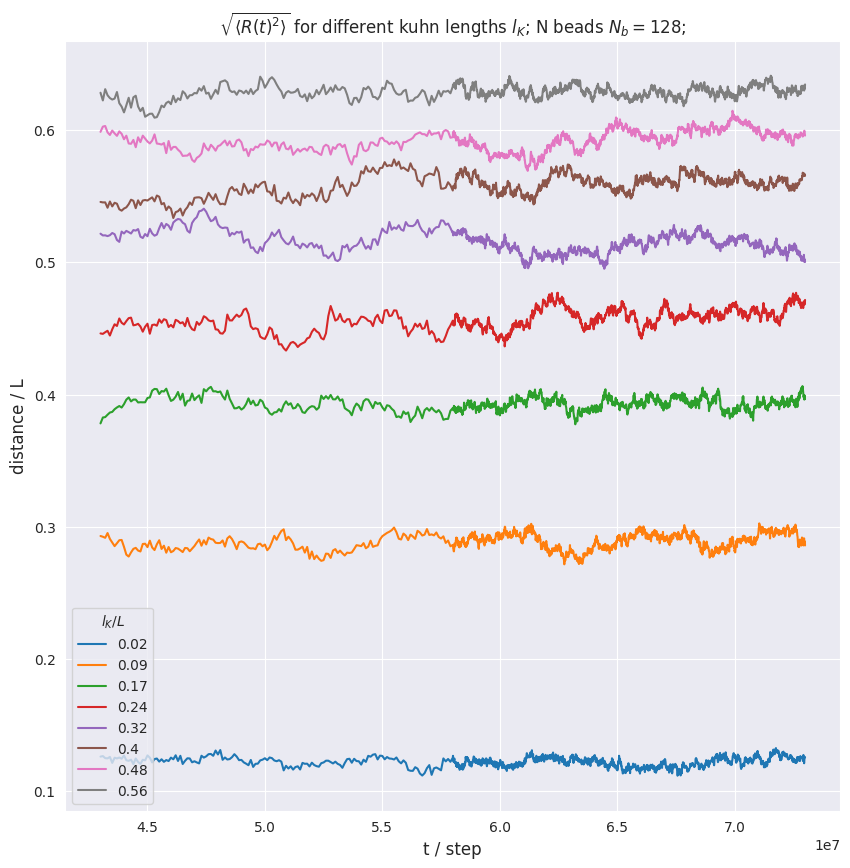

In [23]:
kappa_colors = sns.color_palette(n_colors=len(kappas))

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'$\sqrt{{\\langle R(t)^2 \\rangle }}$ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$;',
    ylabel="distance / L",
    xlabel="t / step"
)

sns.lineplot(
    x=df_ete_mean.index.get_level_values("t"),
    y=np.sqrt(df_ete_mean["R^2"]) / L_src,
    hue=(df_ete_mean["l_K"]/L_src).round(2).astype("category"),
    color=kappa_colors,
    ax=ax
)

ax.get_legend().set_title("$l_K/L$")

## Equilibrium statistics

In [70]:
t_equilibrium = conf.simulation_config.variables["n_relax_steps"] if not CONTINUE else CONTINUE_t_equilibrium
t_equilibrium

58000000

In [71]:
df_trajectory_unfolded_kappas_equi = df_trajectory_unfolded_kappas.loc[df_trajectory_unfolded_kappas["t"] > t_equilibrium]
df_trajectory_unfolded_kappas_equi

t     id  type          x          y          z  ix  iy  iz  \
3891200    58010000      1     1   0.000000   0.000000   0.000000   0   0   0   
3891201    58010000      2     1  -0.159927  -0.017451  -0.956566   0   0   0   
3891202    58010000      3     2  -0.980909  -0.249781  -0.571110   0   0   0   
3891203    58010000      4     2  -1.040590  -0.769522  -1.353570   0   0   0   
3891204    58010000      5     2  -0.569420  -0.776283  -2.201200   0   0   0   
...             ...    ...   ...        ...        ...        ...  ..  ..  ..   
338329595  73000000  25596     2 -10.385500 -62.418301 -40.259701   0   0   0   
338329596  73000000  25597     2 -10.388300 -63.451401 -40.145500   0   0   0   
338329597  73000000  25598     2 -10.585800 -64.320000 -39.889900   0   0   0   
338329598  73000000  25599     2 -10.851100 -65.139801 -39.646099   0   0   0   
338329599  73000000  25600     3 -10.890900 -66.065102 -39.440102   0   0   0   

           molecule-ID kappa  
3891200              1   1.0  
3891201              1   1.0  
3891202              1   1.0  
3891203              1   1.0  
3891204              1   1.0  
...                ...   ...  
338329595          200  36.0  
338329596          200  36.0  
338329597          200  36.0  
338329598          200  36.0  
338329599          200  36.0  

[307200000 rows x 11 columns]

In [72]:
df_ete_kappas_equi = df_ete.iloc[df_ete.index.get_level_values("t") >= t_equilibrium]
df_ete_kappas_equi

R_x       R_y       R_z          R      t/LJ  \
kappa molecule-ID t                                                            
1.0   1           58000000  10.2626   9.39932   7.72573  15.917132  145000.0   
                  58010000  12.1361   9.42624   4.81479  16.103451  145025.0   
                  58020000  12.3665   9.79204   7.01795  17.264588  145050.0   
                  58030000  16.9066   7.06524   4.31075  18.823743  145075.0   
                  58040000  17.2395   2.07281   4.83280  18.023675  145100.0   
...                             ...       ...       ...        ...       ...   
36.0  200         72960000 -13.6698 -58.46460 -44.21120  74.562746  182400.0   
                  72970000 -17.0804 -61.24790 -46.43560  78.735699  182425.0   
                  72980000 -17.1194 -63.68640 -44.13480  79.353084  182450.0   
                  72990000 -18.5015 -62.81360 -44.44030  79.137817  182475.0   
                  73000000 -10.8909 -66.06510 -39.44010  77.709270  182500.0   

                                    R^2  
kappa molecule-ID t                      
1.0   1           58000000   253.355079  
                  58010000   259.321126  
                  58020000   298.065992  
                  58030000   354.333305  
                  58040000   324.852857  
...                                 ...  
36.0  200         72960000  5559.603091  
                  72970000  6199.310266  
                  72980000  6296.911972  
                  72990000  6262.794111  
                  73000000  6038.730629  

[2401600 rows x 6 columns]

In [73]:
df_ete_mean_equi = df_ete_mean.iloc[df_ete_mean.index.get_level_values("t") > t_equilibrium]
df_ete_mean_equi

R^2        l_K
kappa t                               
1.0   58010000   244.191444   1.854017
      58020000   235.037652   1.854017
      58030000   227.478372   1.854017
      58040000   231.709597   1.854017
      58050000   230.876802   1.854017
...                     ...        ...
36.0  72960000  6020.383608  68.870000
      72970000  6055.454135  68.870000
      72980000  6043.288356  68.870000
      72990000  6055.318675  68.870000
      73000000  6108.701851  68.870000

[12000 rows x 2 columns]

### Mean bond length

In [74]:
if CHECK_BOND_LENGTHS:
    l_b_df = transform.extract_bond_lengths_df_kappas(df_trajectory_unfolded_kappas_equi, t_equilibrium=t_equilibrium)
    print(l_b_df.groupby("kappa").describe())

In [75]:
l_b = conf.initial_system_config.system_config.bond_length
l_b

0.97

### Mean contour length

In [76]:
L_contour = l_b*(conf.initial_system_config.system_config.n_monomers-1)
L_contour

123.19

### Kuhn lengths

Svaneborg (8)

In [77]:
l_ks = kremer_grest.bare_kuhn_length(np.array(kappas), l_b)
l_ks

array([ 1.85401695, 10.67085829, 20.37000013, 30.07      , 39.77      ,
       49.47      , 59.17      , 68.87      ])

Estimate from fit (Worm-like chain model, Hinczewski):

In [32]:
l_ks_estimate = transform.estimate_kuhn_length_df(
    df_trajectory_unfolded_kappas_equi,
    group_by_params=["kappa"],
    N_beads=conf.initial_system_config.system_config.n_monomers,
    l_b=l_b,
    n_processes=64
)
l_ks_estimate

l_K     d_l_K
kappa                     
1.0     1.670160  0.000783
6.0    10.679312  0.006884
11.0   20.581019  0.014246
16.0   29.591137  0.023051
21.0   38.975605  0.042683
26.0   48.305775  0.039040
31.0   56.305179  0.065504
36.0   66.164471  0.074460

In [78]:
l_ks_estimate / L_contour

l_K     d_l_K
kappa                    
1.0    0.013558  0.000006
6.0    0.086690  0.000056
11.0   0.167067  0.000116
16.0   0.240207  0.000187
21.0   0.316386  0.000346
26.0   0.392124  0.000317
31.0   0.457060  0.000532
36.0   0.537093  0.000604

Difference of analytical l_K and estimated l_K relative to analytical l_K

In [79]:
np.abs(l_ks - l_ks_estimate["l_K"]) / l_ks

kappa
1.0     0.099167
6.0     0.000792
11.0    0.010359
16.0    0.015925
21.0    0.019975
26.0    0.023534
31.0    0.048417
36.0    0.039285
Name: l_K, dtype: float64

### Number of Kuhn segments $N_K$

Estimate $N_K = L / l_K$ as in Svaneborg (6)

In [80]:
N_Ks = (L_contour / l_ks)
N_Ks

array([66.44491561, 11.54452591,  6.04761901,  4.09677419,  3.09756098,
        2.49019608,  2.08196721,  1.78873239])

### End-to-End distance squared $\langle R^2 \rangle$

Estimate $\langle R^2 \rangle$ as average over ensemble and then over time in equilibrium

In [81]:
df_ete_sq_t_mean_kappas = transform.calculate_ete_sq_t_avg_df_kappas(df_ete_mean_equi, t_equilibrium)
df_ete_sq_t_mean_kappas

R^2
kappa             
1.0     226.138049
6.0    1272.639443
11.0   2344.293455
16.0   3199.878047
21.0   3989.199162
26.0   4767.437961
31.0   5344.002082
36.0   6009.098904

### Summarize statistics by kappas

In [82]:
df_kuhn_summary = pd.DataFrame({
    "R^2": df_ete_sq_t_mean_kappas["R^2"],
    "N_K": N_Ks,
    "l_K": l_ks
}, index=df_ete_sq_t_mean_kappas.index)
df_kuhn_summary

R^2        N_K        l_K
kappa                                   
1.0     226.138049  66.444916   1.854017
6.0    1272.639443  11.544526  10.670858
11.0   2344.293455   6.047619  20.370000
16.0   3199.878047   4.096774  30.070000
21.0   3989.199162   3.097561  39.770000
26.0   4767.437961   2.490196  49.470000
31.0   5344.002082   2.081967  59.170000
36.0   6009.098904   1.788732  68.870000

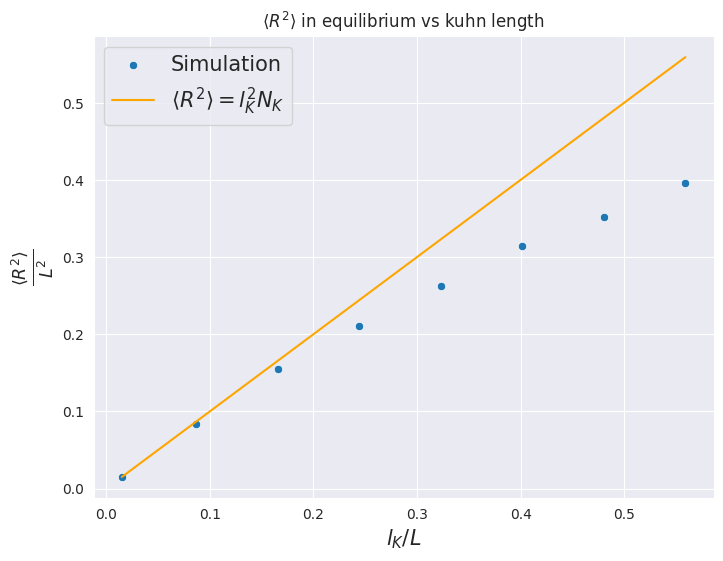

In [83]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(
    x=df_kuhn_summary["l_K"]/L_contour,
    y=df_kuhn_summary["R^2"]/L_contour**2,
    ax=ax,
    label="Simulation"
)

sns.lineplot(
    x=df_kuhn_summary["l_K"]/L_contour,
    y=(df_kuhn_summary["l_K"]**2 * N_Ks) / L_contour**2,
    label=r"$\langle R^2 \rangle = l_K^2 N_K$",
    color="orange"
)

ax.set(
    title=r"$\langle R^2 \rangle$ in equilibrium vs kuhn length",
    xlabel="$l_K / L$",
    ylabel=r"$\frac{\langle R^2 \rangle}{L^2}$"
)

ax.legend(fontsize=15)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(18)

In [84]:
df_kuhn_summary["l_K"]**2 * df_kuhn_summary["N_K"] / df_kuhn_summary["R^2"]

kappa
1.0     1.009986
6.0     1.032927
11.0    1.070421
16.0    1.157645
21.0    1.228133
26.0    1.278299
31.0    1.363988
36.0    1.411875
dtype: float64

### ETE change $ \langle (\Delta R(t))^2 \rangle $

In [58]:
PATH_DF_MSD = PATH_DATA_PROCESSED / "msd.csv"
PATH_DF_MSD

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K/4-FENE-beadspring-vary-l_K/e296c212/data/processed/continue/msd.csv')

In [85]:
if PATH_DF_MSD.exists():
    print("Reading processed ...")
    df_ete_change_kappas_equi = pd.read_csv(PATH_DF_MSD, index_col="t")
else:
    print("Processing ...")
    df_ete_change_kappas_equi = transform.calculate_ens_avg_df_ete_change_kappas(df_ete_kappas_equi)
    df_ete_change_kappas_equi["l_K"] = kremer_grest.bare_kuhn_length(df_ete_change_kappas_equi["kappa"], l_b=l_b)
    df_ete_change_kappas_equi["t/LJ"] = df_ete_change_kappas_equi.index.get_level_values("t").map(lambda t: t*0.0025)
    df_ete_change_kappas_equi["t/LJ"] = df_ete_change_kappas_equi["t/LJ"]-df_ete_change_kappas_equi["t/LJ"].min()
    df_ete_change_kappas_equi.to_csv(PATH_DF_MSD, index=True)

df_ete_change_kappas_equi

Processing ...


dR^2  kappa        l_K     t/LJ
t                                               
58000000     0.000000    1.0   1.854017      0.0
58010000    22.626136    1.0   1.854017     25.0
58020000    34.123844    1.0   1.854017     50.0
58030000    39.739747    1.0   1.854017     75.0
58040000    47.865913    1.0   1.854017    100.0
...               ...    ...        ...      ...
72960000  3979.937271   36.0  68.870000  37400.0
72970000  3991.024708   36.0  68.870000  37425.0
72980000  3991.609027   36.0  68.870000  37450.0
72990000  4018.588179   36.0  68.870000  37475.0
73000000  4030.574721   36.0  68.870000  37500.0

[12008 rows x 4 columns]

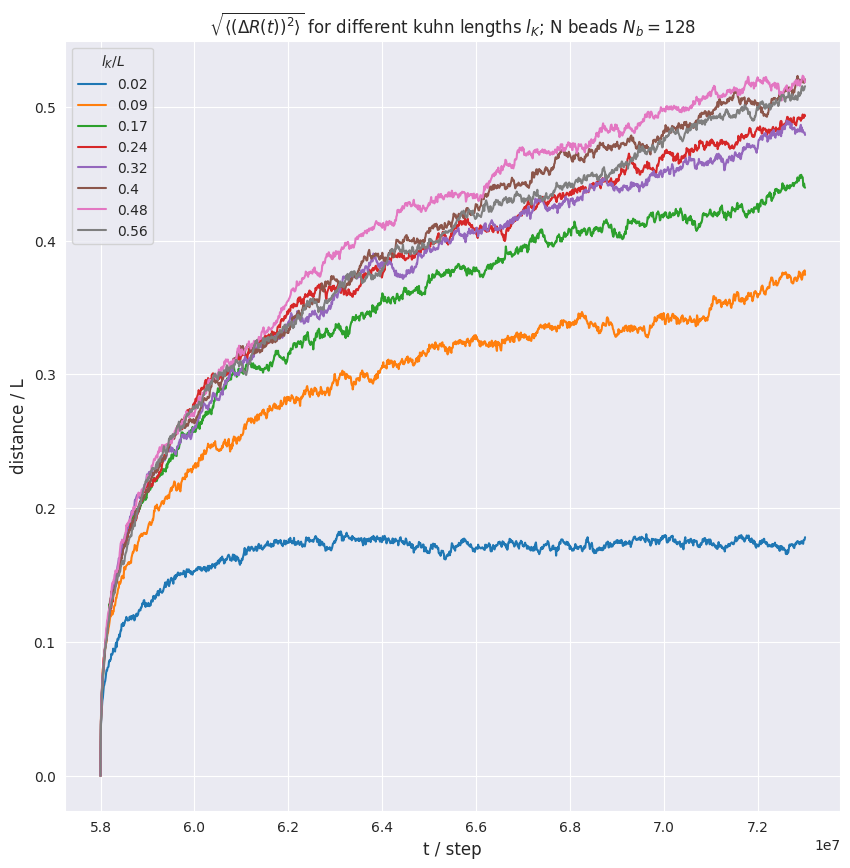

In [86]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / step"
)

sns.lineplot(
    x=df_ete_change_kappas_equi.index.get_level_values("t"),
    y=np.sqrt(df_ete_change_kappas_equi["dR^2"]) / L_contour,
    hue=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    color=kappa_colors,
    ax=ax
)

ax.get_legend().set_title("$l_K/L$")

## Explore MSD

### Loglog scale

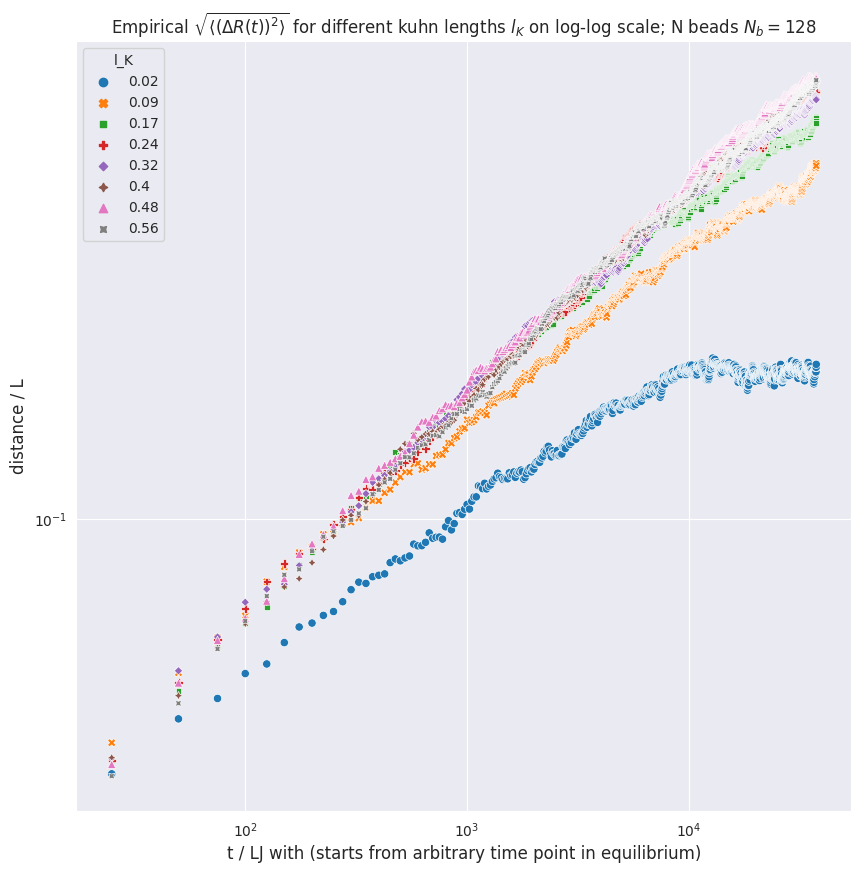

In [87]:
import matplotlib.ticker

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))

plot = sns.scatterplot(
    x=df_ete_change_kappas_equi["t/LJ"],
    y=np.sqrt(df_ete_change_kappas_equi["dR^2"]) / L_contour,
    hue=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    color=kappa_colors,
    style=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    ax=ax
)

_ = ax.set(
    yscale="log",
    xscale="log",
    title=f'Empirical $ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $ for different kuhn lengths $l_K$ on log-log scale; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / LJ with (starts from arbitrary time point in equilibrium)"
)


In [88]:
import plotly.express as px

def plot_msd_plotly(df_msd_kappas: pd.DataFrame, log: bool = False):
    df = df_msd_kappas.copy()

    dR_col = "$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$"
    df[dR_col] = np.sqrt(df["dR^2"]) / L_contour

    l_K_col = "$l_K/L$"
    df[l_K_col] = (df["l_K"]/L_contour).round(2).astype("category")

    fig = px.scatter(
        df,
        x="t/LJ",
        y=dR_col,
        color=l_K_col,
        log_x=log,
        log_y=log,
        title=f'$\\text{{Empirical}} \sqrt {{\langle (\Delta R(t))^2 \\rangle}} \\text{{for different kuhn lengths l_K on log-log scale; N beads}} $N_b={conf.initial_system_config.system_config.n_monomers}$',
        labels={
            dR_col: "$\\text{distance} / L$"
        },
        height=800,
        color_discrete_sequence=px.colors.DEFAULT_PLOTLY_COLORS
    )

    return fig

plot_msd_plotly(df_ete_change_kappas_equi, log=True).show()

## Research different dimensions of MSD

In [89]:
df_ete_main_ax_frame = transform.change_basis_df_ete(df_ete_kappas_equi, df_main_axis)
df_ete_main_ax_frame

R_x        R_y       R_z          R  \
kappa molecule-ID t                                                     
1.0   1           58000000   8.820332   9.256840 -9.479860  15.917132   
                  58010000  11.147968   9.336851 -6.918609  16.103451   
                  58020000  11.010933   9.662404 -9.135824  17.264588   
                  58030000  15.943372   6.985437 -7.165603  18.823743   
                  58040000  16.200672   1.984315 -7.645494  18.023675   
...                               ...        ...       ...        ...   
36.0  200         72960000 -18.089388  71.702741 -9.544317  74.562746   
                  72970000 -21.577416  75.167055 -9.145446  78.735699   
                  72980000 -20.535078  76.398333 -6.206234  79.353084   
                  72990000 -22.055706  75.737743 -6.335158  79.137817   
                  73000000 -12.871171  76.559311 -3.425721  77.709270   

                                t/LJ          R^2  
kappa molecule-ID t                                
1.0   1           58000000  145000.0   253.355079  
                  58010000  145025.0   259.321126  
                  58020000  145050.0   298.065992  
                  58030000  145075.0   354.333305  
                  58040000  145100.0   324.852857  
...                              ...          ...  
36.0  200         72960000  182400.0  5559.603091  
                  72970000  182425.0  6199.310266  
                  72980000  182450.0  6296.911972  
                  72990000  182475.0  6262.794111  
                  73000000  182500.0  6038.730629  

[2401600 rows x 6 columns]

In [90]:
df_msd_by_dim = transform.calculate_msd_by_dimension_df(
    df_ete=df_ete_main_ax_frame,
    group_by_params=["kappa"]
)
df_msd_by_dim["t/LJ"] = df_msd_by_dim.index.get_level_values("t").map(lambda t: t*0.0025)
df_msd_by_dim["t/LJ"] = df_msd_by_dim["t/LJ"]-df_msd_by_dim["t/LJ"].min()
df_msd_by_dim

dR_x^2       dR_y^2       dR_z^2         dR^2  kappa     t/LJ
t                                                                           
58000000     0.000000     0.000000     0.000000     0.000000    1.0      0.0
58010000     7.072284     6.617023     8.936828    22.626136    1.0     25.0
58020000    11.087627    10.321491    12.714726    34.123844    1.0     50.0
58030000    12.795629    12.857548    14.086571    39.739747    1.0     75.0
58040000    16.972668    13.704759    17.188487    47.865913    1.0    100.0
...               ...          ...          ...          ...    ...      ...
72960000  1233.170867  1346.449838  1400.316567  3979.937271   36.0  37400.0
72970000  1246.305694  1341.748098  1402.970916  3991.024708   36.0  37425.0
72980000  1279.876463  1323.309782  1388.422783  3991.609027   36.0  37450.0
72990000  1277.544735  1325.837265  1415.206179  4018.588179   36.0  37475.0
73000000  1270.491731  1366.587647  1393.495343  4030.574721   36.0  37500.0

[12008 rows x 6 columns]

### Different dimensions of same l_K

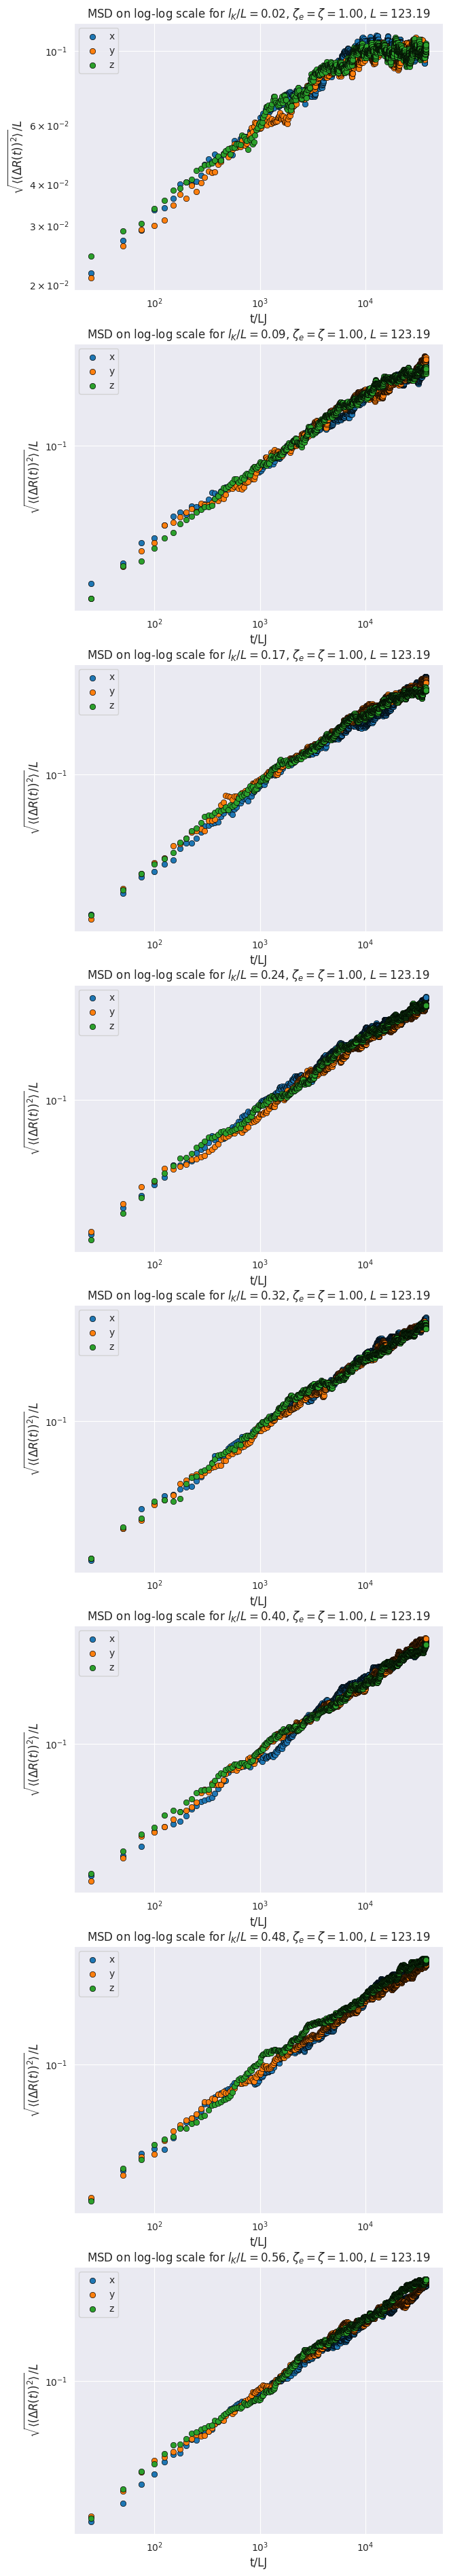

In [101]:
fig: plt.Figure
fig, axs = plt.subplots(nrows=len(kappas), ncols=1, figsize=(7, 6*len(kappas)))
dimensions = ["x", "y", "z"]

for (kappa, df_g), ax in zip(df_msd_by_dim.groupby("kappa"), axs):
    for dim in dimensions:
        plot_msd.plot_MSD(
            df_g,
            log_scale=True,
            l_K=kremer_grest.bare_kuhn_length(kappa, l_b),
            L_contour=L_contour,
            zeta=1,
            zeta_e=1,
            col=f"dR_{dim}^2",
            ax=ax,
            label=dim
        )

### Different l_Ks of same dimension

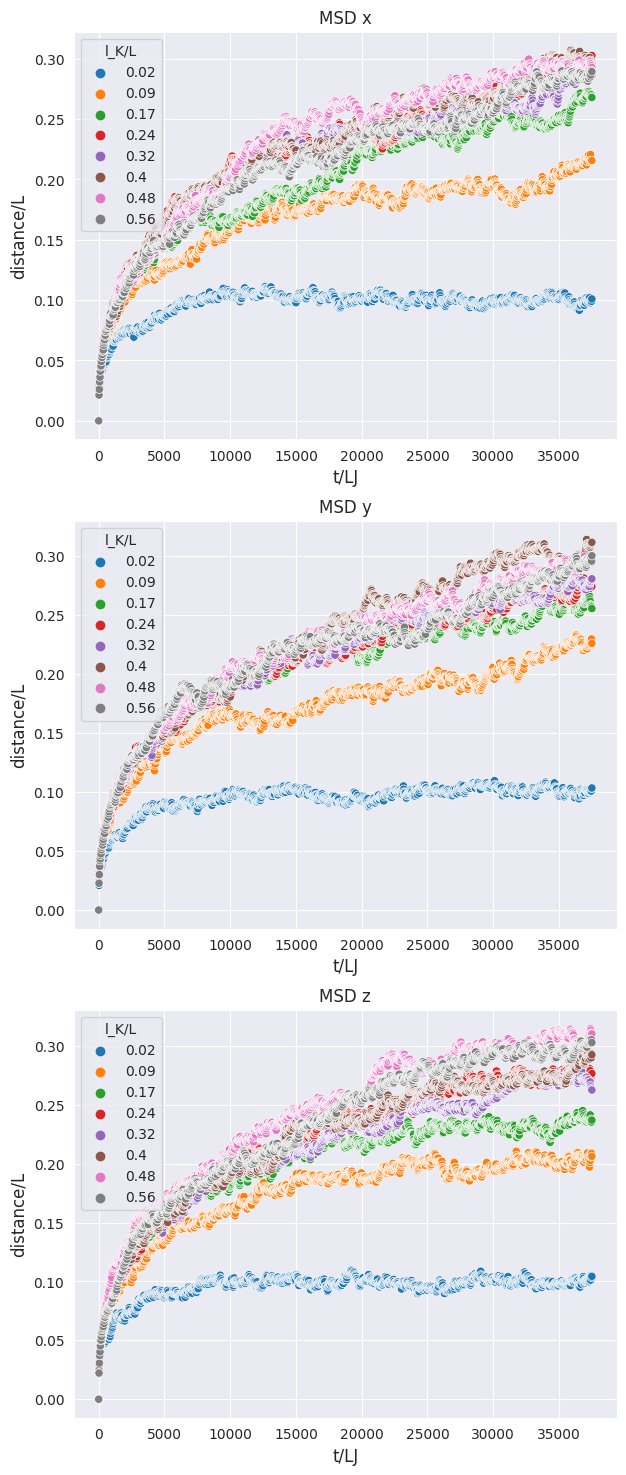

In [109]:
fig: plt.Figure
fig, axs = plt.subplots(nrows=len(dimensions), ncols=1, figsize=(7, 6*len(dimensions)))

def _plot(ax, dim):
    l_Ks = (kremer_grest.bare_kuhn_length(df_msd_by_dim["kappa"], l_b)/L_contour).round(2).astype("category").rename("l_K/L")
    x = df_msd_by_dim["t/LJ"]
    y = np.sqrt(df_msd_by_dim[f"dR_{dim}^2"])/L_contour

    sns.scatterplot(
        x=x,
        y=y,
        hue=l_Ks,
        color=kappa_colors,
        ax=ax
    )

    ax.set(ylabel="distance/L", title=f"MSD {dim}")


for dim, ax in zip(dimensions, axs):
    _plot(ax, dim)


## Compare with Rouse model


### Analytical $\tau_R$

Svaneborg (15)

Rouse relaxation time:
$$ \tau_R = \frac{1}{3 \pi^2} \frac{\zeta_K N_K l_K^2}{k_B T} = \frac{1}{3 \pi^2} \frac{\zeta N_b N_K l_K^2}{k_B T}$$
Relaxation time of single bead:
$$ \tau_0 = \frac{3 \pi^2 \tau_R}{N_K^2} $$

In [120]:
zeta = 1  # LJ
T = 1
k_B = 1
alpha = 4.047

rouse_times_analytical = []
for i, (l_K, N_K, R_sq) in enumerate(zip(df_kuhn_summary["l_K"], df_kuhn_summary["N_K"], df_kuhn_summary["R^2"])):
    tau_R_analytical = zeta*conf.initial_system_config.system_config.n_monomers*N_K*l_K**2 / (3*np.pi**2*k_B*T)
    tau_R_analytical_corrected = tau_R_analytical*alpha
    rouse_times_analytical.append(tau_R_analytical_corrected)

df_rouse_times_theory = pd.DataFrame({
    "l_K": df_kuhn_summary["l_K"],
    "N_K": df_kuhn_summary["N_K"],
    "Theory tau_R": rouse_times_analytical,
    "Theory tau_0": rouse_times_analytical / df_kuhn_summary["N_K"]**2
}, index=df_kuhn_summary.index)

df_rouse_times_theory

l_K        N_K   Theory tau_R  Theory tau_0
kappa                                                   
1.0     1.854017  66.444916    3995.869812      0.905082
6.0    10.670858  11.544526   22998.366031    172.561845
11.0   20.370000   6.047619   43902.440294   1200.382939
16.0   30.070000   4.096774   64808.363827   3861.419656
21.0   39.770000   3.097561   85714.287643   8933.332353
26.0   49.470000   2.490196  106620.211458  17193.822928
31.0   59.170000   2.081967  127526.135273  29420.593301
36.0   68.870000   1.788732  148432.059088  46391.345394

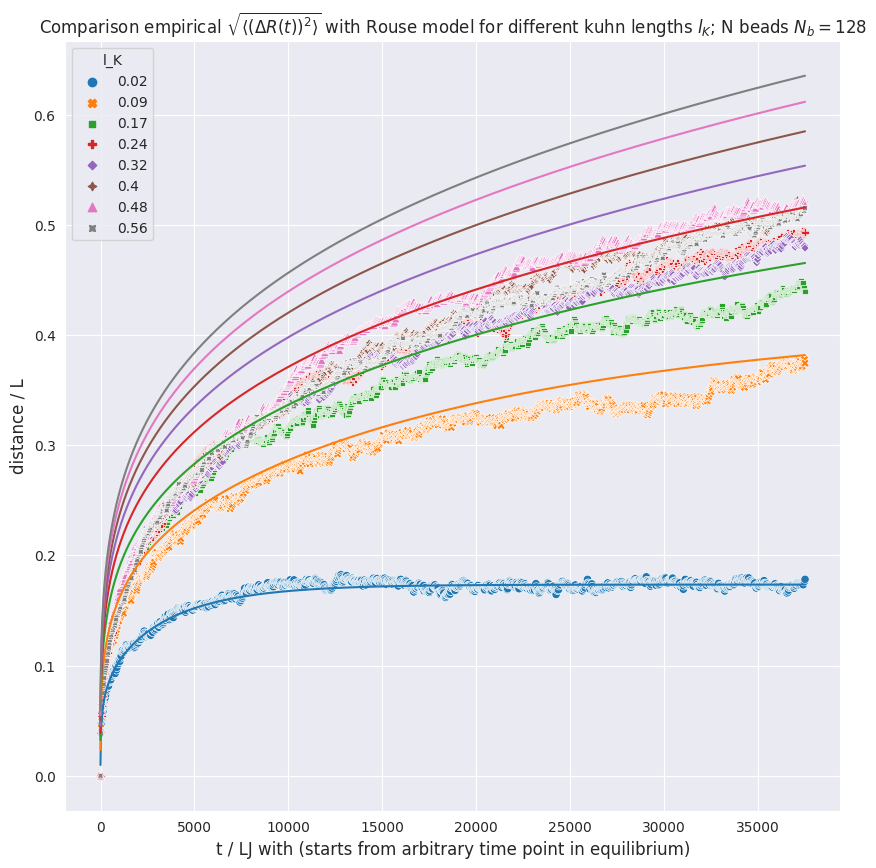

In [105]:
import matplotlib.legend

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'Comparison empirical $ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $ with Rouse model for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / LJ with (starts from arbitrary time point in equilibrium)"
)

plot = sns.scatterplot(
    x=df_ete_change_kappas_equi["t/LJ"],
    y=np.sqrt(df_ete_change_kappas_equi["dR^2"]) / L_contour,
    hue=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    color=kappa_colors,
    style=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    ax=ax
)

lines = []
labels = []

for i, (l_K, N_K, tau_R) in enumerate(zip(df_rouse_times_theory["l_K"], df_rouse_times_theory["N_K"], df_rouse_times_theory["Theory tau_R"])):
    ts = df_ete_change_kappas_equi["t/LJ"].unique()

    rouse_predictions = rouse.rouse_g_4(
        t=ts,
        tau_R=tau_R,
        p_max=conf.initial_system_config.system_config.n_monomers,
        N_b=N_K,
        l_b=l_K
    )
    line = ax.plot(
        ts,
        np.sqrt(rouse_predictions) / L_contour,
        color=kappa_colors[i]
    )
    lines.append(line)
    labels.append(f"$\sqrt{{g_4(t)}}$ for $l_K/L = {np.round(l_K/L_contour, 2)}$")

In [121]:
df_rouse_times_theory

l_K        N_K   Theory tau_R  Theory tau_0
kappa                                                   
1.0     1.854017  66.444916    3995.869812      0.905082
6.0    10.670858  11.544526   22998.366031    172.561845
11.0   20.370000   6.047619   43902.440294   1200.382939
16.0   30.070000   4.096774   64808.363827   3861.419656
21.0   39.770000   3.097561   85714.287643   8933.332353
26.0   49.470000   2.490196  106620.211458  17193.822928
31.0   59.170000   2.081967  127526.135273  29420.593301
36.0   68.870000   1.788732  148432.059088  46391.345394

### Fit $\tau_R$

In [130]:

df_rouse_times_fit = []

for i, (kappa, df_ete_change_kappas_equi_kappa) in enumerate(df_ete_change_kappas_equi.groupby("kappa")):
    l_K = df_kuhn_summary.loc[kappa]["l_K"]
    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    popt, pcov = scipy.optimize.curve_fit(
        functools.partial(rouse.rouse_g_4, N_b=N_K, l_b=l_K, p_max=conf.initial_system_config.system_config.n_monomers),
        df_ete_change_kappas_equi_kappa.loc[df_ete_change_kappas_equi_kappa["t/LJ"]<1e4]["t/LJ"],
        df_ete_change_kappas_equi_kappa[df_ete_change_kappas_equi_kappa["t/LJ"]<1e4]["dR^2"],
        p0=(10**(i+1),) if i!=0 else 100
    )
    df_rouse_times_fit.append((kappa, popt[0], np.sqrt(np.diag(pcov))[0], l_K, N_K))

df_rouse_times_fit = pd.DataFrame(
    df_rouse_times_fit,
    columns=["kappa", "Empirical tau_R", "Empirical Delta tau_R", "l_K", "N_K"]
).set_index("kappa")

df_rouse_times_fit["Empirical tau_0"] = df_rouse_times_fit["Empirical tau_R"] / df_rouse_times_fit["N_K"]**2
df_rouse_times_fit["Empirical Delta tau_0"] = df_rouse_times_fit["Empirical Delta tau_R"] / df_rouse_times_fit["N_K"]**2

df_rouse_times_fit

Empirical tau_R  Empirical Delta tau_R        l_K        N_K  \
kappa                                                                 
1.0        3702.746013              28.257168   1.854017  66.444916   
6.0       26833.045932             134.677656  10.670858  11.544526   
11.0      57566.460090             364.961688  20.370000   6.047619   
16.0     102335.475923             839.878145  30.070000   4.096774   
21.0     196402.945727            1396.224858  39.770000   3.097561   
26.0     288685.125275            2252.572010  49.470000   2.490196   
31.0     375712.349455            2776.444763  59.170000   2.081967   
36.0     551979.426231            4178.659083  68.870000   1.788732   

       Empirical tau_0  Empirical Delta tau_0  
kappa                                          
1.0           0.838688               0.006400  
6.0         201.334300               1.010516  
11.0       1573.985320               9.978803  
16.0       6097.364521              50.041720  
21.0      20469.548749             145.517638  
26.0      46554.033780             363.254994  
31.0      86677.763799             640.532641  
36.0     172517.098867            1306.009079

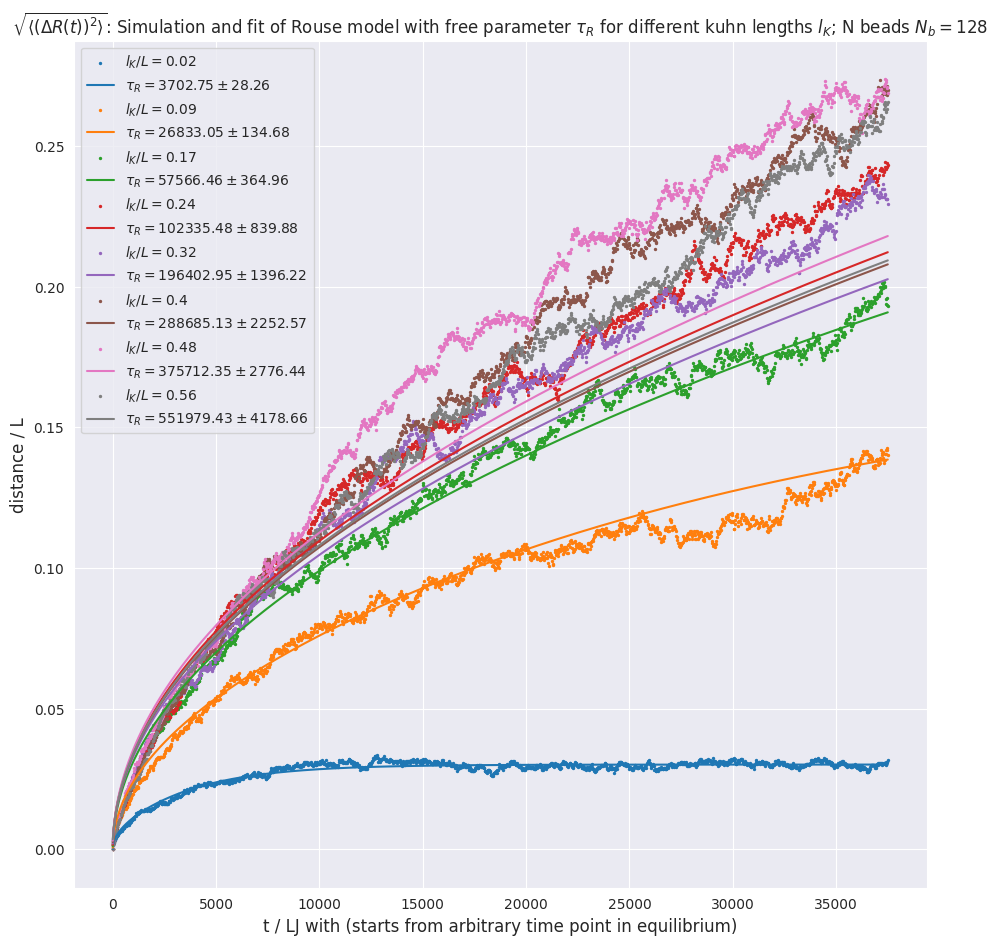

In [131]:
import matplotlib.markers

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(11,11))

for i, (kappa, df_ete_change_kappas_equi_kappa) in enumerate(df_ete_change_kappas_equi.groupby("kappa")):
    l_K = df_kuhn_summary.loc[kappa]["l_K"]
    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    tau_R = df_rouse_times_fit.loc[kappa]["Empirical tau_R"]
    dtau_R = df_rouse_times_fit.loc[kappa]["Empirical Delta tau_R"]

    ax.scatter(
        df_ete_change_kappas_equi_kappa["t/LJ"],
        df_ete_change_kappas_equi_kappa["dR^2"] / L_contour**2,
        label=f"$l_K/L={np.round(l_K/L_contour, 2)}$",
        #marker= list(matplotlib.markers.MarkerStyle.markers.keys())[i],
        color=kappa_colors[i],
        s=2
    )
    ax.plot(
        df_ete_change_kappas_equi_kappa["t/LJ"],
        rouse.rouse_g_4(
            t=df_ete_change_kappas_equi_kappa["t/LJ"],
            N_b=N_K,
            l_b=l_K,
            p_max=conf.initial_system_config.system_config.n_monomers,
            tau_R=tau_R
        ) / L_contour**2,
        label=f"$\\tau_R={tau_R:.2f} \pm {dtau_R:.2f}$",
        color=kappa_colors[i]
    )

ax.legend()

_ = ax.set(
    title=f'$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $: Simulation and fit of Rouse model with free parameter $\\tau_R$ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / LJ with (starts from arbitrary time point in equilibrium)"
)

In [137]:
import matplotlib.markers
import plotly.graph_objects as go

fig: go.Figure = go.Figure()

for i, (kappa, df_ete_change_kappas_equi_kappa) in enumerate(df_ete_change_kappas_equi.groupby("kappa")):
    l_K = df_kuhn_summary.loc[kappa]["l_K"]
    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    tau_R = df_rouse_times_fit.loc[kappa]["Empirical tau_R"]
    dtau_R = df_rouse_times_fit.loc[kappa]["Empirical Delta tau_R"]

    fig.add_trace(go.Scatter(
        x=df_ete_change_kappas_equi_kappa["t/LJ"],
        y=df_ete_change_kappas_equi_kappa["dR^2"] / L_contour**2,
        legendgroup=f"{i}",
        legendgrouptitle_text=f"$l_K/L={np.round(l_K/L_contour, 2)}$",
        name="data",
        marker_color=px.colors.DEFAULT_PLOTLY_COLORS[i],
        mode="markers"
    ))
    fig.add_trace(go.Scatter(
        x=df_ete_change_kappas_equi_kappa["t/LJ"],
        y=rouse.rouse_g_4(
            t=df_ete_change_kappas_equi_kappa["t/LJ"],
            N_b=N_K,
            l_b=l_K,
            p_max=conf.initial_system_config.system_config.n_monomers,
            tau_R=tau_R
        ) / L_contour**2,
        legendgroup=f"{i}",
        name="fit",
        line_color=px.colors.DEFAULT_PLOTLY_COLORS[i]
    ))

fig.update_layout(
    height=900,
    title=f'$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} \\text{{: Simulation and fit of Rouse model with free parameter }} \\tau_R \\text{{ for different kuhn lengths }} l_K; N_b={conf.initial_system_config.system_config.n_monomers}$'
)
fig.update_xaxes(title="t / LJ")
fig.update_yaxes(title="distance / L")

fig.show()

### Compare times

In [138]:
df_rouse_rimes = df_rouse_times_theory.join(df_rouse_times_fit.drop(["l_K", "N_K"], axis=1))
df_rouse_rimes

l_K        N_K   Theory tau_R  Theory tau_0  Empirical tau_R  \
kappa                                                                       
1.0     1.854017  66.444916    3995.869812      0.905082      3702.746013   
6.0    10.670858  11.544526   22998.366031    172.561845     26833.045932   
11.0   20.370000   6.047619   43902.440294   1200.382939     57566.460090   
16.0   30.070000   4.096774   64808.363827   3861.419656    102335.475923   
21.0   39.770000   3.097561   85714.287643   8933.332353    196402.945727   
26.0   49.470000   2.490196  106620.211458  17193.822928    288685.125275   
31.0   59.170000   2.081967  127526.135273  29420.593301    375712.349455   
36.0   68.870000   1.788732  148432.059088  46391.345394    551979.426231   

       Empirical Delta tau_R  Empirical tau_0  Empirical Delta tau_0  
kappa                                                                 
1.0                28.257168         0.838688               0.006400  
6.0               134.677656       201.334300               1.010516  
11.0              364.961688      1573.985320               9.978803  
16.0              839.878145      6097.364521              50.041720  
21.0             1396.224858     20469.548749             145.517638  
26.0             2252.572010     46554.033780             363.254994  
31.0             2776.444763     86677.763799             640.532641  
36.0             4178.659083    172517.098867            1306.009079

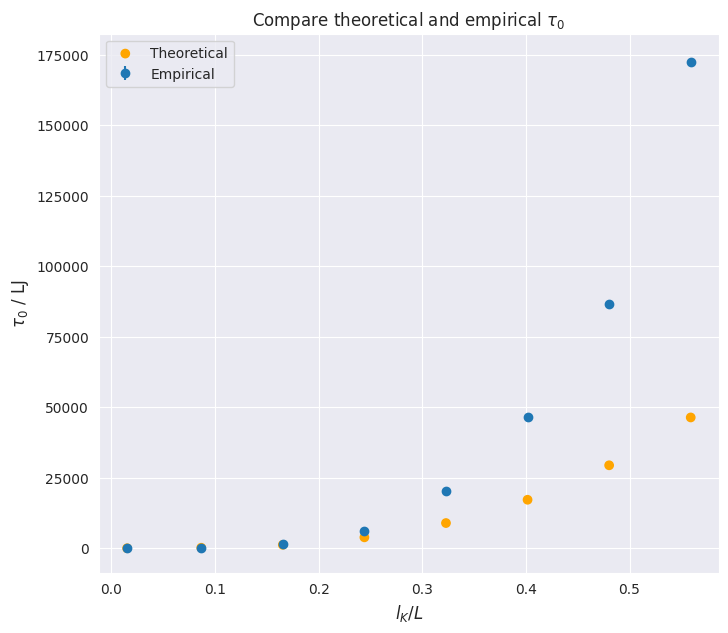

In [139]:
import matplotlib.container
import matplotlib.collections

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(8,7))

errorbar_container: matplotlib.container.ErrorbarContainer = ax.errorbar(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=df_rouse_rimes["Empirical tau_0"],
    yerr=df_rouse_rimes["Empirical Delta tau_0"],
    linestyle="",
    marker="o",
    label="Empirical",
)

ax.set(
    xlabel="$l_K/L$",
    ylabel="$\\tau_0$ / LJ",
    title="Compare theoretical and empirical $\\tau_0$"
)

path_coll: matplotlib.collections.PathCollection = ax.scatter(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=df_rouse_rimes["Theory tau_0"],
    linestyle="",
    marker="o",
    label="Theoretical",
    color="orange",
)

ax.legend()

[Text(0.5, 0, '$l_K/L$'),
 Text(0, 0.5, '$\\Delta \\tau_0$ / LJ'),
 Text(0.5, 1.0, 'Empirical $\\tau_0$ - Theoretical $\\tau_0$')]

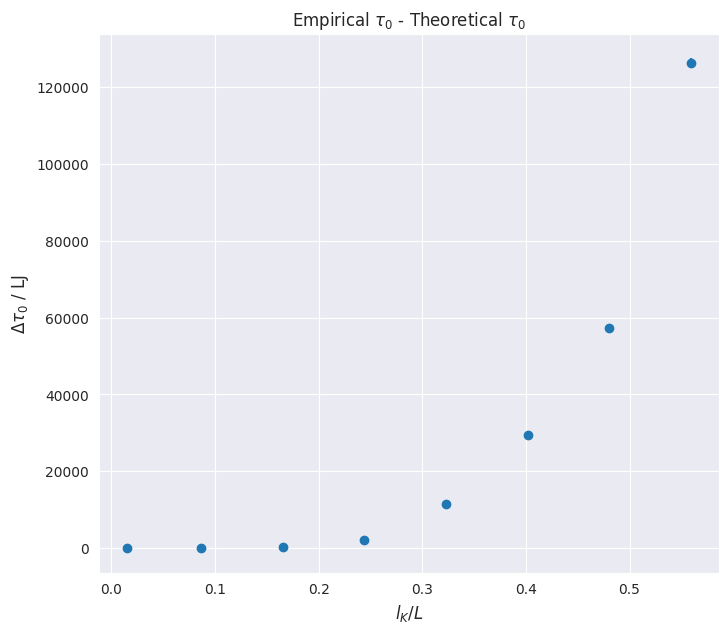

In [140]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(8,7))


errorbar_container: matplotlib.container.ErrorbarContainer = ax.errorbar(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=df_rouse_rimes["Empirical tau_0"] - df_rouse_rimes["Theory tau_0"],
    yerr=df_rouse_rimes["Empirical Delta tau_0"],
    linestyle="",
    marker="o",
    label="Empirical - Theory",
)

ax.set(
    xlabel="$l_K/L$",
    ylabel="$\\Delta \\tau_0$ / LJ",
    title="Empirical $\\tau_0$ - Theoretical $\\tau_0$"
)

In [110]:
import plotly
plotly.offline.init_notebook_mode(connected=False)